# Part-of-speech Tagging using Bi-LSTM
- https://wikidocs.net/33532

## import

In [1]:
import nltk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

## Load dataset

In [2]:
# import nltk
# nltk.download('treebank')

In [3]:
tagged_sentences = nltk.corpus.treebank.tagged_sents() # 토큰화에 품사 태깅이 된 데이터 받아오기
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences))

품사 태깅이 된 문장 개수:  3914


In [4]:
tagged_sentences[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

## Preprocessing

In [5]:
sentences, pos_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    pos_tags.append(list(tag_info))
len(sentences), len(pos_tags)

(3914, 3914)

샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


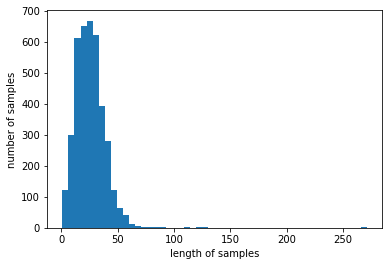

In [6]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### integer encoding

In [7]:
def tokenize(samples):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(samples)
    return tokenizer

In [8]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [82]:
x_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)
len(x_train), len(y_train)

(3914, 3914)

### padding

In [83]:
max_len = 150
x_train = pad_sequences(x_train, padding="post", maxlen=max_len)
y_train = pad_sequences(y_train, padding="post", maxlen=max_len)
x_train.shape, y_train.shape

((3914, 150), (3914, 150))

### to categorical

In [84]:
y_train = to_categorical(y_train)
y_train.shape

(3914, 150, 47)

### split dataset

In [85]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3131, 150), (783, 150), (3131, 150, 47), (783, 150, 47))

## Train model

### Define model

In [86]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation="softmax")))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 128)          1457664   
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 512)          788480    
_________________________________________________________________
time_distributed (TimeDistri (None, 150, 47)           24111     
Total params: 2,270,255
Trainable params: 2,270,255
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(0.001),
    metrics=["accuracy"]
)

### Train

In [88]:
model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=6,
    validation_data=(x_test, y_test)
)

Train on 3131 samples, validate on 783 samples
Epoch 1/6
3131/3131 [==============================] - 55s 17ms/sample - loss: 0.5658 - accuracy: 0.1415 - val_loss: 0.5216 - val_accuracy: 0.1777
Epoch 2/6
3131/3131 [==============================] - 51s 16ms/sample - loss: 0.4884 - accuracy: 0.2299 - val_loss: 0.4766 - val_accuracy: 0.3537
Epoch 3/6
3131/3131 [==============================] - 69s 22ms/sample - loss: 0.4078 - accuracy: 0.4260 - val_loss: 0.3419 - val_accuracy: 0.5031
Epoch 4/6
3131/3131 [==============================] - 52s 17ms/sample - loss: 0.2609 - accuracy: 0.6118 - val_loss: 0.2049 - val_accuracy: 0.7167
Epoch 5/6
3131/3131 [==============================] - 66s 21ms/sample - loss: 0.1412 - accuracy: 0.8181 - val_loss: 0.1128 - val_accuracy: 0.8550
Epoch 6/6
3131/3131 [==============================] - 55s 17ms/sample - loss: 0.0728 - accuracy: 0.9086 - val_loss: 0.0745 - val_accuracy: 0.8934


### Evaluate

In [89]:
model.evaluate(x_test, y_test, verbose=2)

783/1 - 4s - loss: 0.0680 - accuracy: 0.8934


[0.07445709408281102, 0.8934303]

In [92]:
index_to_word=src_tokenizer.index_word
index_to_tag=tar_tokenizer.index_word

i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([x_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(x_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
as               : IN      IN
mr.              : NNP     NNP
whiting          : NNP     NNP
describes        : VBZ     NNP
it               : PRP     PRP
,                : ,       ,
nipponese        : JJ      NNP
baseball         : NN      NN
is               : VBZ     VBZ
a                : DT      DT
``               : ``      ``
mirror           : NN      NN
of               : IN      IN
japan            : NNP     NNP
's               : POS     POS
fabled           : JJ      JJ
virtues          : NNS     NN
of               : IN      IN
hard             : JJ      JJ
work             : NN      NN
and              : CC      CC
harmony          : NN      NN
.                : .       .
''               : ''      ''
